In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
import pickle, gzip, urllib.request, json

In [2]:
#To ensure reproducibility
random.seed(11)
np.random.seed(11)

In [3]:
# Load the dataset
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

# Get the data into arrays
images = train_set[0]
labels = train_set[1]

# Put aside an array for the patterns
patterns = np.zeros((10,784))
    
# Set aside one image per class to store (10 images in total)
for category in range(10):
    inclass = [i for i in range(labels.shape[0]) if labels[i] == category]
    patterns[category,:] = 1.0*(images[inclass[random.randint(0,len(inclass))],:] > 0)

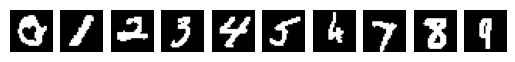

In [4]:
#Plot the patterns we're going to store
fig, axs = plt.subplots(1,10)
for c in range(10):
    axs[c].imshow(patterns[c,:].reshape((28,28)), cmap='gray')
    axs[c].axis("off")
plt.show()

Flattened pixel values:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.      

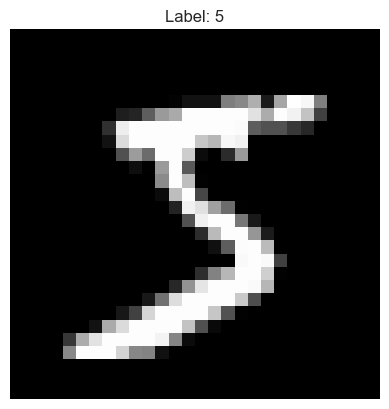

In [5]:
"""
Our pixels are normalized, so every pixel is a value between 0 and 1
"""

# Select an image by index
image_index = 0  # You can change this to any index
image_pixels = images[image_index]

# Print pixel values as a flattened array
print("Flattened pixel values:\n", image_pixels)

# Reshape to 28x28 and print the matrix
image_matrix = image_pixels.reshape((28, 28))
print("Pixel values as a 28x28 matrix:\n", image_matrix)

# Visualize the image
plt.imshow(image_matrix, cmap='gray')
plt.title(f"Label: {labels[image_index]}")
plt.axis("off")
plt.show()

In [6]:
import numpy as np

class hopfield_network(object):
    """
    A class for a Hopfield network.
    The network stores binary patterns (images) using Hebbian learning and retrieves the closest stored pattern
    when provided with a noisy or incomplete input.
    """

    # Initialization function for the Hopfield network
    def __init__(self, N, lr=0.01):
        """
        Initializes the Hopfield network.
        
        Args:
            N (int): Number of neurons in the network (equal to the number of pixels in the image).
            lr (float): Learning rate (optional, typically not used in standard Hopfield networks).
        
        Variables:
            self.state (np.array): Represents the current state of the network neurons.
            self.w (np.array): Weight matrix (NxN) for synaptic connections between neurons.
        """
        self.state = np.zeros((N,))  # Initialize the neuron state vector to zeros
        self.w = np.zeros((N, N))  # Initialize weights to zeros
        np.fill_diagonal(self.w, 0)  # No self-connections (W_ii = 0)
        self.lr = lr  # Learning rate (included for potential extensions)

    # Function to set the current state of the network
    def set_state(self, activity):
        """
        Sets the current state of the network.
        
        Args:
            activity (np.array): Binary pattern to set as the current state (elements should be +1 or -1).
        """
        self.state = activity

    # Function to update a single neuron's state randomly based on energy minimization
    def update(self):
        """
        Randomly selects a neuron and updates its state based on the local field (weighted input from other neurons).
        
        Returns:
            Updated network state after one neuron update.
        """
        i = np.random.choice(len(self.state))  # Randomly select a neuron
        h = np.dot(self.w[i, :], self.state)  # Compute the local field for neuron i

        # Update the neuron's state based on the sign of the local field
        if h >= 0:
            self.state[i] = 1
        else:
            self.state[i] = -1

        return self.state  # Return updated state for tracking purposes

    # Function to store a single image pattern using Hebbian learning
    def store_one(self, image):
        """
        Stores a single image (pattern) in the network using Hebbian learning.
        
        Args:
            image (np.array): Input image to be stored, converted into binary form (+1, -1).
        """
        flattened_image = image.flatten()  # Flatten the 2D image into a 1D array
        activity = np.where(flattened_image > 0.5, 1, -1)  # Convert pixels to binary states

        self.set_state(activity)  # Set the state to the activity pattern

        # Update weights according to Hebbian learning rule
        N = len(self.state)
        for i in range(N):
            for j in range(N):
                if i != j:
                    # Hebbian learning rule: store pattern by strengthening connections
                    self.w[i, j] = (activity[i] * activity[j]) / N

        np.fill_diagonal(self.w, 0)  # Remove self-connections (W_ii = 0)

    # Function to store multiple patterns using Hebbian learning
    def store_multi(self, images):
        """
        Stores multiple images (patterns) using Hebbian learning.
        
        Args:
            images (list): List of images to be stored (converted into binary states).
        """
        N = len(images[0].flatten())  # Get the size of the image
        self.w = np.zeros((N, N))  # Reset the weights for fresh training

        for image in images:
            flattened_image = image.flatten()
            activity = np.where(flattened_image > 0.5, 1, -1)  # Convert to binary states

            # Hebbian learning update for multiple patterns
            for i in range(N):
                for j in range(N):
                    if i != j:
                        # Incrementally update weights for each pattern
                        self.w[i, j] += (activity[i] * activity[j]) / N

        np.fill_diagonal(self.w, 0)  # Ensure no self-connections after weight update

    # Runs the network until a stable state is reached (or until max_steps is reached)
    def run_until_convergence(self, max_steps=4000):
        """
        Runs the network until it converges (no state changes) or until the maximum number of steps is reached.
        
        Args:
            max_steps (int): Maximum number of updates before stopping.
        
        Returns:
            np.array: The final state of the network after convergence.
        """
        for _ in range(max_steps):
            previous_state = self.state.copy()  # Save the current state
            self.update()  # Perform a state update for a random neuron
            if np.array_equal(previous_state, self.state):
                # Stop updating if the network has converged to a stable state
                break
        return self.state  # Return the final state after convergence


In [7]:
# Some helper functions for generating test images

# The function for generating a noisy version of an image
def image_noise(image,noise_level=0.1):
    """
    new_image = test_noise(image)
        
    This function takes an image, adds noise to it, and returns it. 

    noise_level - between 0-1, try experimenting with this

    """
    
    # create a mask for adding noise to the image
    image_mask = random.uniform(size=image.shape) < noise_level
    
    return np.logical_xor(image,image_mask)
    
# The function for generating a combo of two images
def image_combo(image1,image2,image1_weight=0.5):
    """
    newimage = test_combo(image1,image2)
        
    This function takes a pair of images, combines them, and returns the result.
    
    image1_weight - between 0-1, try experimenting with this

    """
    
    # create a mask for mixing the images
    image1_mask = random.uniform(size=image1.shape) < image1_weight
        
    return image1_mask*image1 + (1-image1_mask)*image2

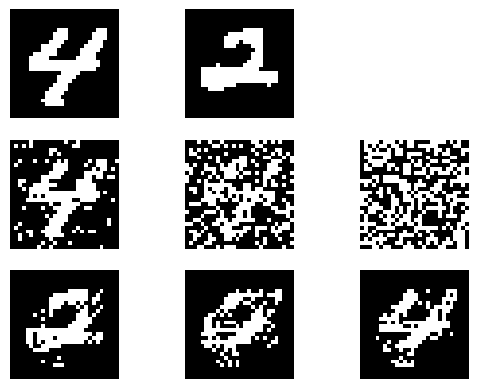

In [8]:
# Test the helper functions to make sure they work

# Pick some random images
image1 = patterns[random.randint(0,10)]
image2 = patterns[random.randint(0,10)]

# Create a little array for storage
test_images = np.zeros((2,3,784))

# Generate a series of noise images
test_images[0,0,:] = image_noise(image1)
test_images[0,1,:] = image_noise(image1,noise_level=0.3)
test_images[0,2,:] = image_noise(image1,noise_level=0.5)

# Generate a series of combo images
test_images[1,0,:] = image_combo(image1,image2,image1_weight=0.2)
test_images[1,1,:] = image_combo(image1,image2)
test_images[1,2,:] = image_combo(image1,image2,image1_weight=0.8)

# Plot the images, plus the originals on top
fig, axs = plt.subplots(3,3)
axs[0,0].imshow(image1.reshape((28,28)), cmap='gray')
axs[0,0].axis("off")
axs[0,1].imshow(image2.reshape((28,28)), cmap='gray')
axs[0,1].axis("off")
axs[0,2].axis("off")
for c in range(3):
    axs[1,c].imshow(test_images[0,c,:].reshape((28,28)), cmap='gray')
    axs[1,c].axis("off")
    axs[2,c].imshow(test_images[1,c,:].reshape((28,28)), cmap='gray')
    axs[2,c].axis("off")
plt.show()

In [9]:
# Create a Hopfield network and train it

one_pattern = False # flag for whether to store one pattern at a time

hnet = hopfield_network(784) # construct the network

if one_pattern:
    # Train the network to store all the patterns using your store_one function
    hnet.store_one(image1)
    
else:
    # Train the network to store all the patterns using your store_multi function 

    # Store multiple images
    hnet.store_multi([image1, image2])

## Part 3

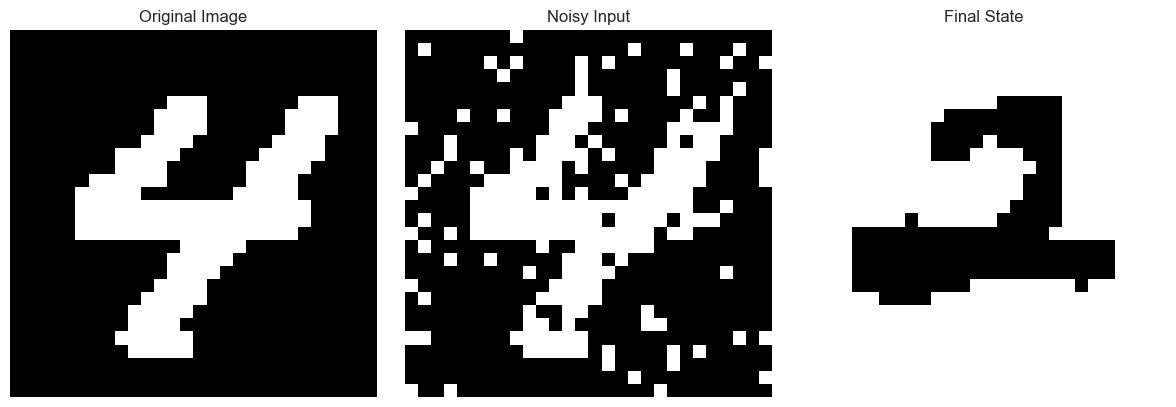

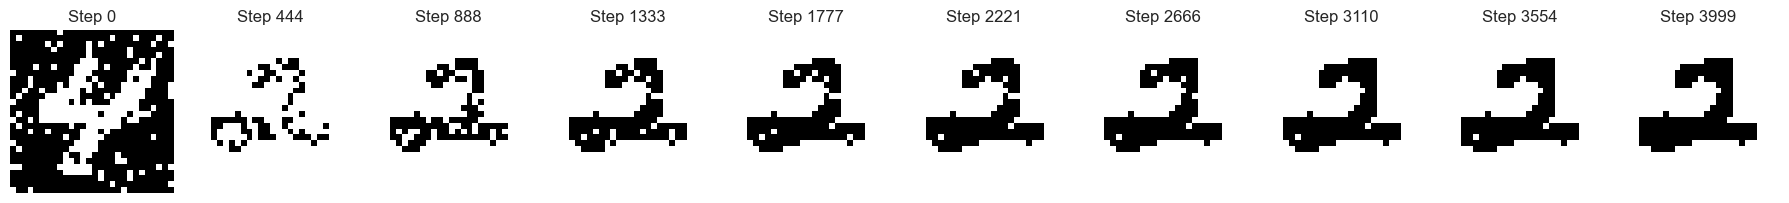

In [10]:
# Plot generated images from your Hopfield network as it updates after receiving an initial pattern that is

# number of time-steps to run the network for
numsteps = 4000 # feel free to change this


# a noisy version of an image that was stored
activity = np.zeros((numsteps,784)) # each row is a timestep 
activity[0,:] = image_noise(image1, noise_level=0.1)
hnet.set_state(activity[0,:])


for t in range(numsteps-1):
    activity[t+1,:] = hnet.update()
    activity[t+1, :] = np.where(activity[t+1, :] >= 0, 1, -1)
    hnet.set_state(activity[t+1,:])


# Plot the original image, noisy input, and final recovered state
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Original image
axs[0].imshow(image1.reshape((28, 28)), cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

# Noisy input
axs[1].imshow(activity[0, :].reshape((28, 28)), cmap='gray')
axs[1].set_title("Noisy Input")
axs[1].axis("off")

# Final recovered state
axs[2].imshow(activity[-1, :].reshape((28, 28)), cmap='gray')
axs[2].set_title("Final State")
axs[2].axis("off")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Number of snapshots
num_snapshots = 10
snapshot_indices = np.linspace(0, numsteps - 1, num_snapshots, dtype=int)

# Create the plot (only 1 row now)
fig, axs = plt.subplots(1, num_snapshots, figsize=(18, 3))

# Bottom row: Snapshots over time
for i, idx in enumerate(snapshot_indices):
    axs[i].imshow(activity[idx, :].reshape((28, 28)), cmap='gray')
    axs[i].set_title(f"Step {idx}")
    axs[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


### Part 3 Bonus

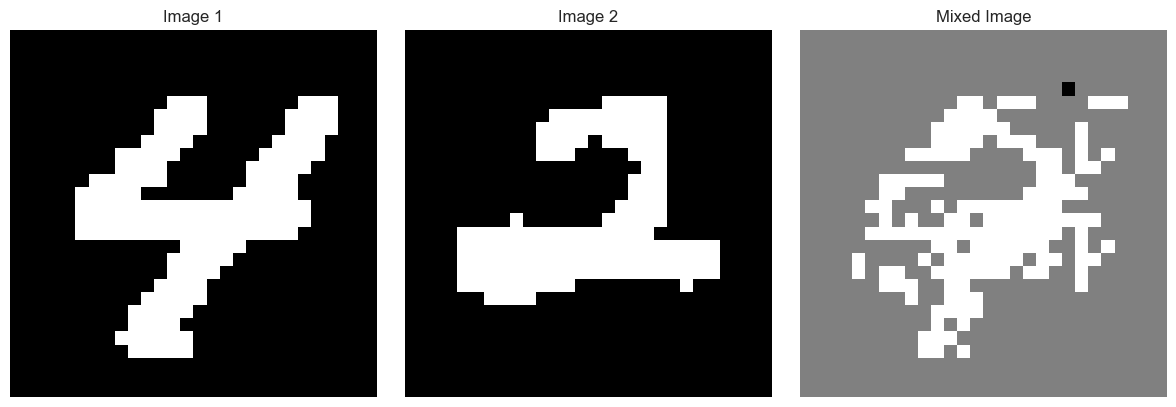

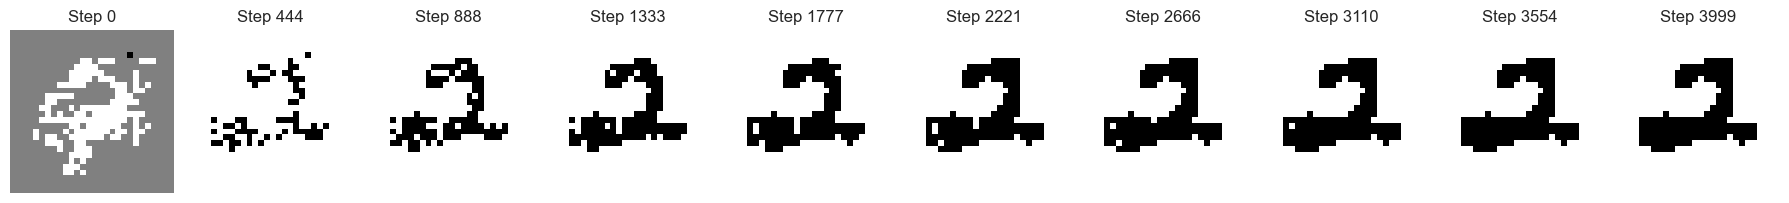

In [11]:
# Plot generated images from your Hopfield network as it updates after receiving an initial pattern that is
# a combination of two images that were stored

# number of time-steps to run the network for
numsteps = 4000 # feel free to change this

# create an array for storing activity states over time
activity = np.zeros((numsteps,784))


activity[0,:] = image_combo(image1,image2)
hnet.set_state(activity[0,:])
for t in range(numsteps-1):
    activity[t+1,:] = hnet.update()
    activity[t+1, :] = np.where(activity[t+1, :] >= 0, 1, -1)
    hnet.set_state(activity[t+1,:])

# Plot the original image, noisy input, and final recovered state
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# image 1
axs[0].imshow(image1.reshape((28, 28)), cmap='gray')
axs[0].set_title("Image 1")
axs[0].axis("off")

# image 2
axs[1].imshow(image2.reshape((28, 28)), cmap='gray')
axs[1].set_title("Image 2")
axs[1].axis("off")

# mixed image
axs[2].imshow(activity[0,:].reshape((28, 28)), cmap='gray')
axs[2].set_title("Mixed Image")
axs[2].axis("off")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Number of snapshots
num_snapshots = 10
snapshot_indices = np.linspace(0, numsteps - 1, num_snapshots, dtype=int)

# Create the plot (only 1 row now)
fig, axs = plt.subplots(1, num_snapshots, figsize=(18, 3))

# Bottom row: Snapshots over time
for i, idx in enumerate(snapshot_indices):
    axs[i].imshow(activity[idx, :].reshape((28, 28)), cmap='gray')
    axs[i].set_title(f"Step {idx}")
    axs[i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()